# CS5481 - Tutorial 7
## Recommendation system

Welcome to CS5481 tutorial. In this tutorial, you will learn to utilize python to implement different recommendation system methods.

## preparation
- Python
- Python Libraries
  - Matplotlib
  - pands
  - numpy
  - sklearn
  - os
  - tqdm

In [1]:
! pip install matplotlib
! pip install pandas
! pip install numpy
! pip install sklearn
! pip install tqdm

# 1. Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as MAE
import os
from tqdm import tqdm

# 2. Recommendation system methods

## 2. 1 User-based collaborative filtering on MovieLens-100k dataset
User-based collaborative filtering aims to find the similarity between users. As long as we find the preferred items of similar users and predict the target user's rating for the corresponding objects, we can find the highest-rating items and recommend them to the user.

### 2.1.1 Hyper-parameters setting

In [3]:
# Hyper-parameters for recommendation system
topK = 20# number of the top-k nearest neighbors
testRate = 0.2# testing rate
seed = 2# random seed
staticDir='ml-100k'

### 2.1.2 Data loading and training/test set split

In [4]:
users = pd.read_table(staticDir+'/u.user',sep="|",names=['user_id','age','sex','occupation','zip_code'],encoding='latin-1',engine='python')
ratings = pd.read_table(staticDir+'/u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'unix_timestamp'],encoding='latin-1',engine='python')
movies = pd.read_table(staticDir+'/u.item',engine='python', sep='|',header=None,encoding='latin-1',names=['movie_id','title','release_date','video_release_date','IMDb_URL','unknown','Action','Adventure','Animation','Children','Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western']) 
movies = movies.iloc[:,:5]
#index setting
users = users.set_index(['user_id'],drop=False)
movies = movies.set_index(['movie_id'],drop=False)
ratings = ratings.set_index(['user_id','movie_id'],drop=False) 

In [5]:
# Visualize user information
users.head()

,user_id,age,sex,occupation,zip_code
user_id,,,,,
1,1,24,M,technician,85711
2,2,53,F,other,94043
3,3,23,M,writer,32067
4,4,24,M,technician,43537
5,5,33,F,other,15213


In [6]:
# Visualize movie information
movies.head() 

,movie_id,title,release_date,video_release_date,IMDb_URL
movie_id,,,,,
1,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...
2,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...
3,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...
4,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...
5,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995)


In [7]:
# Visualize rating information
ratings.head()

,,user_id,movie_id,rating,unix_timestamp
user_id,movie_id,,,,
196,242,196,242,3,881250949
186,302,186,302,3,891717742
22,377,22,377,1,878887116
244,51,244,51,2,880606923
166,346,166,346,1,886397596


In [8]:
#training/test data split
np.random.seed(seed)
testIndex = np.random.choice(range(ratings.shape[0]),size=int(ratings.shape[0]*testRate),replace=False)
testRatings = ratings.iloc[testIndex,:]
trainIndex = list(set(range(ratings.shape[0]))-set(testIndex))
trainRatings = ratings.iloc[trainIndex,:]

### 2.1.3 Training set process

In [9]:
# Counting the user IDs of all movies in the training set watched in the training set
def calUsers(movieId):
    try:
        views = trainRatings.loc[(slice(None),movieId),:]
    except:
        return []
    users = views['user_id'].values.tolist()
    return users
movies['users'] = movies['movie_id'].apply(calUsers)
movies.head()

,movie_id,title,release_date,video_release_date,IMDb_URL,users
movie_id,,,,,,
1,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,"[308, 287, 148, 280, 66, 109, 181, 95, 189, 14..."
2,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,"[5, 268, 276, 87, 250, 201, 64, 13, 213, 373, ..."
3,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,"[181, 81, 130, 49, 320, 145, 95, 99, 267, 417,..."
4,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,"[99, 19, 207, 295, 201, 10, 308, 328, 109, 334..."
5,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),"[293, 43, 311, 109, 344, 145, 314, 308, 280, 4..."


In [10]:
# Counting the movie ids watched by users in all training sets 
def calMovies(userId):
    try:
        views = trainRatings.loc[(userId,slice(None)),:]
    except:
        return []
    movies = views['movie_id'].values.tolist()
    return movies
users['movies'] = users['user_id'].apply(calMovies)
users.head()

,user_id,age,sex,occupation,zip_code,movies
user_id,,,,,,
1,1,24,M,technician,85711,"[61, 189, 33, 160, 20, 202, 171, 265, 117, 47,..."
2,2,53,F,other,94043,"[292, 251, 314, 297, 312, 281, 13, 303, 308, 2..."
3,3,23,M,writer,32067,"[335, 245, 337, 343, 323, 331, 294, 332, 334, ..."
4,4,24,M,technician,43537,"[264, 303, 361, 357, 260, 356, 294, 288, 50, 2..."
5,5,33,F,other,15213,"[2, 439, 225, 110, 454, 424, 363, 98, 102, 211..."


### 2.1.4 Similarity measure
\begin{equation}
Sim_{u,v}=\frac{|\text { items}_{\text {user}_u} \cap \text {items}_{\text {user}_v}|}{|\sqrt{\text {items}_{\text {user}_u} |\times |\text { items}_{\text {user}_v}|}}
\end{equation}
where $\text{items}_{\text {user}_u}$ represents the viewing records of $\text {user}_u$. Generally, the denominator denotes the square root of multiplication between the cardinality of movie recording of $\text {user}_u$ and $\text {user}_v$. Similarly, the numerator is the cardinality of the intersection of $\text {user}_u$ and $\text {user}_v$.

In [11]:
sims = pd.DataFrame(0,columns=users.index,index=users.index)
def calSim(userId1,userId2):
    user1Items = users.loc[userId1,'movies']
    user2Items = users.loc[userId2,'movies']
    cross = list(set(user1Items) & set(user2Items))
    sim = len(cross)/((max(1e-1,len(user1Items))*max(1e-1,len(user2Items)))**0.5)
    return sim 
def fillSims(row):
    userIds = pd.Series(row.index)
    row[:] = userIds.apply(calSim,args=(row.name,))
    return row
sims = sims.apply(fillSims,axis=1)
sims.iloc[:5,:5]

user_id,1,2,3,4,5
user_id,,,,,
1,1.000000,0.116008,0.069067,0.064449,0.275500
2,0.116008,1.000000,0.142887,0.133333,0.036380
3,0.069067,0.142887,1.000000,0.238145,0.012377
4,0.064449,0.133333,0.238145,1.000000,0.040423
5,0.275500,0.036380,0.012377,0.040423,1.000000


### 2.1.5 Calculating the top-k nearest neighbors of $\text {user}_u$
We select top-k nearest neighbors of $\text {user}_u$ and present them in a new colunm named "near".

In [12]:
def calNearUsers(userId):
    nearUserIds = sims.loc[:,userId].sort_values(ascending=False)[1:topK+1]
    nearUserIds = nearUserIds.index.tolist()
    return nearUserIds
users['near'] = users['user_id'].apply(calNearUsers)
users.head()


,user_id,age,sex,occupation,zip_code,movies,near
user_id,,,,,,,
1,1,24,M,technician,85711,"[61, 189, 33, 160, 20, 202, 171, 265, 117, 47,...","[457, 435, 916, 648, 933, 276, 864, 297, 805, ..."
2,2,53,F,other,94043,"[292, 251, 314, 297, 312, 281, 13, 303, 308, 2...","[701, 673, 926, 131, 306, 569, 937, 520, 486, ..."
3,3,23,M,writer,32067,"[335, 245, 337, 343, 323, 331, 294, 332, 334, ...","[752, 489, 784, 587, 863, 529, 783, 428, 126, ..."
4,4,24,M,technician,43537,"[264, 303, 361, 357, 260, 356, 294, 288, 50, 2...","[33, 816, 750, 408, 443, 783, 725, 596, 355, 6..."
5,5,33,F,other,15213,"[2, 439, 225, 110, 454, 424, 363, 98, 102, 211...","[222, 648, 407, 56, 495, 254, 497, 457, 727, 1..."


### 2.1.6 Prediction and evaluation
Predicting the scores of $\text {user}_0$ on $\text {t}_1$ and evaluate the performance on test data via mean absolute error.
\begin{equation}
P_{\mathrm{u} 0, t 1}=\frac{\sum_{\mathrm{ui} \in A_{u 0}} \operatorname{sim}(u i, u 0) \times\left(R_{u i, t 1}\right)}{\sum_{u i \in A_{u 0}}|\operatorname{sim}(u i, u 0)|}
\end{equation}
where A_{u 0} denotes the set of neighbors of $\text {user}_0$. $\operatorname{sim}(u i, u 0)$ represents the similarity score between users and $R_{u i, t 1}$ is the rate score of neighbor user $ui$ on item $t1$.

In [13]:
def predict(row):
    userId = row['user_id']
    movieId = row['movie_id']
    #select top-K nearest neighbors
    nearUserIds = users.loc[userId,'near']
    #index the movie_id of user in the training set
    itemUserIds = movies.loc[movieId,'users']
    #calculate the user intersection of the same item
    cross = list(set(nearUserIds) & set(itemUserIds))   
    #predict the scores
    up = 0
    down = 0
    for nearUserId in cross:
        sim = sims.loc[nearUserId,userId]
        down += sim
        #Scores from neighboring users
        score = trainRatings.loc[(nearUserId,movieId),'rating']
        up += score * sim
    if up == 0:
        return None
    else:
        return up/down
    
#Testing
testRatings['predict'] = testRatings.apply(predict,axis=1)
testRatings = testRatings.dropna()
mae = MAE(testRatings['rating'],testRatings['predict'])
print('The MAE of test set is %.2f'%mae)
testRatings.head()

The MAE of test set is 0.84


<ipython-input-13-69cf05875b94>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testRatings['predict'] = testRatings.apply(predict,axis=1)


,,user_id,movie_id,rating,unix_timestamp,predict
user_id,movie_id,,,,,
157,273,157,273,5,886889876,3.740361
405,1065,405,1065,1,885546069,3.790151
244,550,244,550,1,880602264,3.164083
378,768,378,768,4,880333598,2.786181
919,111,919,111,4,875288681,3.691650


## 2. 2 Matrix factorization on MovieLens-1m dataset for top-k recommendation
Matrix factorization factorizes the user-item rating matrix to fill in the missing rate values. 
Given $n$ users and $m$ items, the user-item rating matrix is represented as $R_{n\times m}$, the mathematic concept of matrix factorization can be formulated as 
\begin{equation}
\mathbf{R}_{n\times m} \approx \mathbf{P}_{n\times k} \times \mathbf{Q}_{k\times m}=\hat{\mathbf{R}}_{n\times m}.
\end{equation}
Matrix $P$ represents the association between a user and the features while matrix $Q$ represents the association between an item and the features. We can get the prediction of a rating of an item by the calculation of the dot product of the $i$-th user and j-th item as follows:
\begin{equation}
\hat{r}_{i j}=p_i^T q_j=\sum_{k=1}^k p_{i k} q_{k j}.
\end{equation}

We utilize the mean square error to measure the difference between $\mathbf{R}_{n\times m}$ and $\hat{\mathbf{R}}_{n\times m}$ as:
\begin{equation}
e_{i j}^2=\left(r_{i j}-\hat{r}_{i j}\right)^2=\left(r_{i j}-\sum_{k=1}^K p_{i k} q_{k j}\right)^2.
\end{equation}

and utilize the gradient descent to minimize the error. The updates of each entry of $\mathbf{P}$ and $\mathbf{Q}$ can be presented as:
\begin{equation}
\begin{aligned}
&p_{i k}^{\prime}=p_{i k}+\alpha \frac{\partial}{\partial p_{i k}} e_{i j}^2=p_{i k}+2 \alpha e_{i j} q_{k j}, \\
&q_{k j}^{\prime}=q_{k j}+\alpha \frac{\partial}{\partial q_{k j}} e_{i j}^2=q_{k j}+2 \alpha e_{i j} p_{i k}.
\end{aligned}
\end{equation}

### 2.2.1 Data loading and U-I rating matrix building

In [14]:
data_item_list = []
split="::"
for data_item in open('ml-1m/ratings.dat'):
    # data_item_list：[(6040, 858, 4, 956703932), (1, 593, 3, 1112484661), ...]
    temp_tuple = list(data_item.strip().split(split)[:4])  # delimiter
    temp_tuple[0] = int(temp_tuple[0])  # user ID
    temp_tuple[1] = int(temp_tuple[1])  # item ID
    temp_tuple[2] = int(temp_tuple[2])  # item rating，
    temp_tuple[3] = int(temp_tuple[3])  # timestamp
    data_item_list.append(tuple(temp_tuple))
# We order data_item_list based on the timestamp and the user ID
data_item_list = sorted(data_item_list, key=lambda tup: tup[3])
data_item_list = sorted(data_item_list, key=lambda tup: tup[0])
data_item_list

[(1, 3186, 4, 978300019),
 (1, 1270, 5, 978300055),
 (1, 1721, 4, 978300055),
 (1, 1022, 5, 978300055),
 (1, 2340, 3, 978300103),
 (1, 1836, 5, 978300172),
 (1, 3408, 4, 978300275),
 (1, 2804, 5, 978300719),
 (1, 1207, 4, 978300719),
 (1, 1193, 5, 978300760),
 (1, 720, 3, 978300760),
 (1, 260, 4, 978300760),
 (1, 919, 4, 978301368),
 (1, 608, 4, 978301398),
 (1, 2692, 4, 978301570),
 (1, 1961, 5, 978301590),
 (1, 2028, 5, 978301619),
 (1, 3105, 5, 978301713),
 (1, 938, 4, 978301752),
 (1, 1035, 5, 978301753),
 (1, 1962, 4, 978301753),
 (1, 2018, 4, 978301777),
 (1, 150, 5, 978301777),
 (1, 1028, 5, 978301777),
 (1, 1097, 4, 978301953),
 (1, 914, 3, 978301968),
 (1, 1287, 5, 978302039),
 (1, 2797, 4, 978302039),
 (1, 2762, 4, 978302091),
 (1, 1246, 4, 978302091),
 (1, 661, 3, 978302109),
 (1, 2918, 4, 978302124),
 (1, 531, 4, 978302149),
 (1, 3114, 4, 978302174),
 (1, 2791, 4, 978302188),
 (1, 2321, 3, 978302205),
 (1, 1029, 5, 978302205),
 (1, 1197, 3, 978302268),
 (1, 594, 4, 97830226

In [15]:
def getUIMat(data):
    # build U-I rating matrix
    user_list = [i[0] for i in data]
    item_list = [i[1] for i in data]
    UI_matrix = np.zeros((max(user_list) + 1, max(item_list) + 1))
    for each_interaction in tqdm(data, total=len(data)):
        UI_matrix[each_interaction[0]][each_interaction[1]] = each_interaction[2]
    return UI_matrix
R = getUIMat(data_item_list)
R

100%|██████████| 1000209/1000209 [00:00<00:00, 1560300.74it/s]


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 3., 0., ..., 0., 0., 0.]])

### 2.2.2 Matrix factorization model building

In [16]:
class MF():
    def __init__(self, R, K, alpha, beta, iterations):
        """
        parameters
        - R (ndarray)   : user-item rating matrix
        - K (int)       : dimension of hidden features隐特征维度
        - alpha (float) : learning rate
        - beta (float)  : regularization parameter
        """

        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations

    def train(self):
        # Initialize the hidden user-feature matrix and item-feature matrix 初始化用户和项目隐特征矩阵
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Initialize biases
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])

        # Building training samples
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]

        # Iterate the gradient descent to update matrices
        training_process = []
        for i in tqdm(range(self.iterations), total=self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            if (i == 0) or ((i+1) % (self.iterations / 10) == 0):
                print("Iteration: %d ; error = %.4f" % (i+1, mse))

        return training_process
    
    def mse(self):
        """
        Mean square error
        """
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)/len(self.R)

    def sgd(self):
        """
        Stochastic gradient descent
        """
        for i, j, r in self.samples:
            # calculate the prediction and error
            prediction = self.get_rating(i, j)
            e = (r - prediction)

            # update biases
            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])

            # update user and item hidden feature matrices
            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])

    def get_rating(self, i, j):
        """
        Get preficted score (r_ij)，where i is the user id and j denotes item id
        """
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    def full_matrix(self):
        """
        Obtain the fully prediction matrix
        """
        return self.b + self.b_u[:,np.newaxis] + self.b_i[np.newaxis:,] + self.P.dot(self.Q.T)

### 2.2.3 Training and testing

In [17]:
#Train the MF model
mf = MF(R, K=20, alpha=0.01, beta=0.3, iterations=5)
mf.train()

# ------ Recommendation example ------ #
# Recommend top-10 items to user_1
each_user = 1
user_ratings = mf.full_matrix()[each_user].tolist()
# print(user_ratings)
topN = [(i, user_ratings.index(i)) for i in user_ratings] # Correlate the item id with corresponding scores
topN = [i[1] for i in sorted(topN, key=lambda x:x[0], reverse=True)][:10]

print("------ user ------")
print(each_user)
print("------ temp_topN ------")
print(topN)

 20%|██        | 1/5 [00:19<01:18, 19.67s/it]

Iteration: 1 ; error = 0.1534



 40%|████      | 2/5 [00:39<00:58, 19.57s/it]

Iteration: 2 ; error = 0.1521



 60%|██████    | 3/5 [00:58<00:39, 19.68s/it]

Iteration: 3 ; error = 0.1516



 80%|████████  | 4/5 [01:18<00:19, 19.70s/it]

Iteration: 4 ; error = 0.1514


100%|██████████| 5/5 [01:38<00:00, 19.68s/it]

Iteration: 5 ; error = 0.1514
------ user ------
1
------ temp_topN ------
[2905, 922, 318, 2019, 750, 1148, 3030, 858, 1178, 745]


# 3. Practice--Linear regression for recommendation

Linear regression is also a popular method to fill up the missing rates. Traditionally, for linear regression, the formula is usually written as:
\begin{equation}
h=\theta_0+\theta_1 X
\end{equation}
Here, $h$ is the hypothesis or the predicted value, $X$ is the input feature, and $\theta_0$ and $\theta_1$ are the coefficients.

In this recommendation system, we will use the other ratings of the same movie as the input X and predict the missing values. We will avoid the bias term $\theta_0$. We define the total loss function which will indicate the distance between the predicted ratings and the original ratings as follows:


\begin{equation}
\begin{aligned}
&J\left(x^1, \ldots, x^{n_m}, \theta^1, \ldots, \theta^{n_u}\right) \\
&\quad=\frac{1}{2} \sum_{(i, j): r(i, j)=1}\left(\left(\theta^j\right)^T x^i-y^{i, j}\right)^2+\frac{\lambda}{2} \sum_{i=1}^{n_m} \sum_{k=1}^n\left(x_k^i\right)^2+\frac{\lambda}{2} \sum_{j=1}^{n_u} \sum_{k=1}^n\left(\theta_k^j\right)^2
\end{aligned}
\end{equation}

where $r(i, j)$ indicate whether user $j$ has rated movie $i$, $y^{i, j}$ is the rate score given by user $j$ to movie $i$. 
The first term of this formula shows the squared of the error term. We take the square to avoid any negative values. Use 1/2 to optimize the squared and we calculate the error term where r(i, j) = 1. The second and third term of the equation above is the regularization term. The first regularization is used for finding features X that belongs to same movie category and the second one is is useful to regularize any overfitting or underfitting problem.

After we getting the loss function, the gradient descent updates the theta in each iteration. Here is the formula for gradient descent:
\begin{equation}
\theta_k^j=\theta_k^j-\alpha\left(\sum_{i: r(i, j)=1}\left(\left(\theta^j\right)^T x^i-y^{i, j}\right) x_k^i+\lambda \theta_k^j\right)
\end{equation}
\begin{equation}
x_k^i=x_k^i-\alpha\left(\sum_{j: r(i, j)=1}\left(\left(\theta^j\right)^T x^i-y^{i, j}\right) \theta_k^j+\lambda x_k^i\right)
\end{equation}
where $\alpha$ is the learning rate. In each iteration, $\theta$ and $X$ will be updated and eventually becomes stable.

In this practice, you need to write codes to implement the linear regression on a new dataset from Andrew Ngs. 

In [18]:
import numpy as np
import pandas as pd

In [19]:
# loading movie rate
y = pd.read_excel('ex8_movies.xlsx', sheet_name = 'y', header=None)
y.head()

,0,1,2,3,4,5,6,7,8,9,...,933,934,935,936,937,938,939,940,941,942
0,5,4,0,0,4,4,0,0,0,4,...,2,3,4,0,4,0,0,5,0,0
1,3,0,0,0,3,0,0,0,0,0,...,4,0,0,0,0,0,0,0,0,5
2,4,0,0,0,0,0,0,0,0,0,...,0,0,4,0,0,0,0,0,0,0
3,3,0,0,0,0,0,5,0,0,4,...,5,0,0,0,0,0,2,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# That means we have 1682 movies and 943 users.
y.shape

(1682, 943)

In [21]:
# This dataset contains true if the user provided a rating and False if the user did not provide the rating.
r = pd.read_excel('ex8_movies.xlsx', sheet_name='R', header=None)
r.head()

,0,1,2,3,4,5,6,7,8,9,...,933,934,935,936,937,938,939,940,941,942
0,True,True,False,False,True,True,False,False,False,True,...,True,True,True,False,True,False,False,True,False,False
1,True,False,False,False,True,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,True
2,True,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
3,True,False,False,False,False,False,True,False,False,True,...,True,False,False,False,False,False,True,False,False,False
4,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [22]:
# We need to convert these boolean values into numeric values. I will replace True with 1 and False with 0.
for i in range(len(r.columns)):
    r[i] = r[i].replace({True: 1, False: 0})

In [23]:
# We have features X in this dataset:
X = pd.read_excel('movie_params.xlsx', sheet_name='X', header=None)
X.head()

,0,1,2,3,4,5,6,7,8,9
0,1.048686,-0.400232,1.194119,0.371128,0.407607,0.974407,-0.058410,0.861721,-0.697290,0.288746
1,0.780851,-0.385626,0.521198,0.227355,0.570109,0.641264,-0.550006,0.704021,-0.485835,-0.564624
2,0.641509,-0.547854,-0.083796,-0.598519,-0.017694,0.299736,-0.720807,0.838546,-0.694832,-1.134796
3,0.453618,-0.800218,0.680481,-0.081743,0.136601,0.907561,0.277682,0.369300,-1.261208,-0.235581
4,0.937538,0.106090,0.361953,0.086646,0.287505,0.518644,-0.056871,0.914573,-0.819334,-0.542847


In [24]:
# We have 10 features of each movie.
X.shape

(1682, 10)

In [26]:
def costfunction(X, y, r, theta, Lambda):
    """
    Please code below
    Input parameters
        - X: movie feature
        - y: rate values
        - r: rate index
        - theta: theta value in linear regression
        - Lambda: hyper-parameter to regulate the effects of regularization
    Outputs:
        - J: mean square error between predicted and real rates
        - grad: total loss
    """
    predictions = np.dot(X, theta.T)
    err = predictions-y
    J = 1/2 * np.sum((err**2) * r)
    reg_x = Lambda/2 * np.sum(np.sum(theta**2))
    reg_theta = Lambda/2 * np.sum(np.sum(X**2))
    grad = J + reg_x + reg_theta
    return J, grad

In [27]:
def gradientDescent(X, y, r, theta, Lambda, num_iter, alpha):
    """
    Please code below
    Input parameters
        - X: movie feature
        - y: rate values
        - r: rate index
        - theta: theta value in linear regression
        - Lambda: hyper-parameter to regulate the effects of regularization
        - num_iter: number of iteration
        - alpha: learning rate
    Outputs:
        - X: updated X
        - theta: updated theta
        - J_hist: a list that collects the error between predicted and real rates in every iteration
    """
    J_hist = []
    for i in range(num_iter):
        cost, grad = costfunction(X, y, r, theta, Lambda)
        X = X -  alpha*(np.dot(np.dot(X, theta.T) - y, theta) + Lambda*X)
        theta = theta - alpha*(np.dot((np.dot(X, theta.T) - y).T, X) + Lambda*theta) 
        J_hist.append(cost)
    return X, theta, J_hist

In [28]:
#Recommend a Movie For us
#To recommend movies for us, we need to provide ratings for some moves.
my_ratings = np.zeros((1682,1))
my_ratings[5] = 5 
my_ratings[50] = 1
my_ratings[9] = 5
my_ratings[27]= 4
my_ratings[58] = 3
my_ratings[88]= 2
my_ratings[123]= 4
my_ratings[165] = 1
my_ratings[187]= 3
my_ratings[196] = 2
my_ratings[228]= 4
my_ratings[258] = 5 
my_ratings[343] = 4
my_ratings[478] = 1
my_ratings[511]= 4
my_ratings[690] = 5
my_ratings[722]= 1
my_ratings[789]= 3
my_ratings[832] = 2
my_ratings[1029]= 4
my_ratings[1190] = 2
my_ratings[1245]= 5

#We will add our ratings in the ‘y’ DataFrame now.
y1 = np.hstack((my_ratings, y))

# We also need to update r 
my_r = np.zeros((1682,1))
for i in range(len(r)):
    if my_ratings[i] !=0:
        my_r[i] = 1
r1 = np.hstack((my_r, r))

In [29]:
#Let’s try to recommend movies for me using randomly initialized theta.
num_users = y1.shape[1]
num_movies = y1.shape[0]
num_features = 10
Theta1 = np.random.randn(num_users, num_features)
x_up, theta_up, J_hist = gradientDescent(np.array(X), np.array(y1), np.array(r1), Theta1, 10, 500,0.001)

Text(0.5, 1.0, 'Cost function using Gradient Descent')

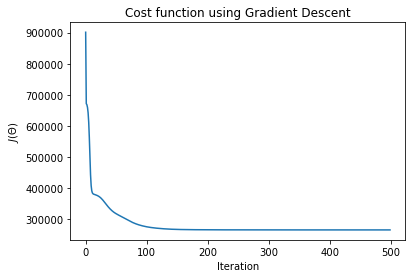

In [30]:
# So, we got the cost data for every iteration. Let’s plot it.
import matplotlib.pyplot as plt
plt.figure()
plt.plot(J_hist)
plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Gradient Descent")

In [31]:
#Notice, we did not rate all the movies. 
#So, here using the updated parameters we will predict the ratings for all the movies for all the users.
p = np.dot(x_up, theta_up.T)

In [32]:
#Now, our ratings were in the first column as we added using np.hstack. 
#Separate my ratings only and normalize it using the ‘ymean’ that came out from the ‘normalizeRatings’ function.
def normalizeRatings(y, r):
    ymean = np.sum(y, axis=1)/np.sum(r, axis=1)
    ynorm = np.sum(y, axis=1)*np.sum(r, axis=1) - ymean
    return ymean, ynorm
ymean, ynorm = normalizeRatings(y1, r1)
my_predictions = p[:, 0] + ymean
my_predictions = pd.DataFrame(my_predictions)

In [33]:
#Now, I will add these ratings to the movie list. First import the movie list.
movies = open('movie_ids.txt', 'r').read().split("\n")
df = pd.DataFrame(np.hstack((my_predictions,np.array(movies)[:,np.newaxis])))

In [34]:
#We have the movie list and our ratings side by side now in a DataFrame. 
#If we just sort this DataFrame my_ratings, we will find the top-recommended movies for myself. 
#Here we get the top 10 recommended movies according to our ratings:
df.sort_values(by=[0],ascending=False,inplace=True)
df.head(10)

,0,1
813,5.0101143229808995,"814 Great Day in Harlem, A (1994)"
1499,5.010071588890922,1500 Santa with Muscles (1996)
1188,5.0088768121355045,1189 Prefontaine (1997)
1200,5.0070972610739926,1201 Marlene Dietrich: Shadow and Light (1996)
1652,5.001855099056595,1653 Entertaining Angels: The Dorothy Day Stor...
1292,5.001805157988351,1293 Star Kid (1997)
1535,5.0010705252942165,1536 Aiqing wansui (1994)
1598,5.000011503286801,1599 Someone Else's America (1995)
1121,4.999123325635195,1122 They Made Me a Criminal (1939)
1466,4.998606614423978,"1467 Saint of Fort Washington, The (1993)"
